In [1]:
from abc import ABC
from pathlib import Path
import re
import random
from fastai.vision.all import *
from fastai.callback.fp16 import *


In [3]:
!curl -o ./images.tar "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
!tar -xf images.tar
dataset_path = Path('Images')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  4100k      0  0:03:08  0:03:08 --:--:-- 6192k756M   27  208M    0     0  2215k      0  0:05:49  0:01:36  0:04:13 1241k


In [4]:

BREED_NAMES = {'n02085620': 'Chihuahua', 'n02085782': 'Japanese Spaniel', 'n02085936': 'Maltese Dog', 'n02086079': 'Pekinese', 'n02086240': 'Shih-Tzu', 'n02086646': 'Blenheim Spaniel', 'n02086910': 'Papillon', 'n02087046': 'Toy Terrier', 'n02087394': 'Rhodesian Ridgeback', 'n02088094': 'Afghan Hound', 'n02088238': 'Basset', 'n02088364': 'Beagle', 'n02088466': 'Bloodhound', 'n02088632': 'Bluetick', 'n02089078': 'Black-And-Tan Coonhound', 'n02089867': 'Walker Hound', 'n02090379': 'Redbone', 'n02090622': 'Borzoi', 'n02090721': 'Irish Wolfhound', 'n02091032': 'Italian Greyhound', 'n02091134': 'Whippet', 'n02091244': 'Ibizan Hound', 'n02091467': 'Norwegian Elkhound', 'n02091831': 'Saluki', 'n02092002': 'Scottish Deerhound', 'n02092339': 'Weimaraner', 'n02093256': 'Staffordshire Bullterrier', 'n02093428': 'American Staffordshire Terrier', 'n02093647': 'Bedlington Terrier', 'n02093754': 'Border Terrier', 'n02093859': 'Kerry Blue Terrier', 'n02093991': 'Irish Terrier', 'n02094114': 'Norfolk Terrier', 'n02094258': 'Norwich Terrier', 'n02094433': 'Yorkshire Terrier', 'n02095314': 'Wire-Haired Fox Terrier', 'n02095570': 'Lakeland Terrier', 'n02095889': 'Sealyham Terrier', 'n02096051': 'Airedale', 'n02096177': 'Cairn', 'n02096294': 'Australian Terrier', 'n02096437': 'Dandie Dinmont', 'n02096585': 'Boston Bull', 'n02097047': 'Miniature Schnauzer', 'n02097130': 'Giant Schnauzer', 'n02097209': 'Standard Schnauzer', 'n02097298': 'Scotch Terrier', 'n02097474': 'Tibetan Terrier', 'n02097658': 'Silky Terrier', 'n02098105': 'Soft-Coated Wheaten Terrier', 'n02098286': 'West Highland White Terrier', 'n02098413': 'Lhasa', 'n02099267': 'Flat-Coated Retriever', 'n02099429': 'Curly-Coated Retriever', 'n02099601': 'Golden Retriever', 'n02099712': 'Labrador Retriever', 'n02099849': 'Chesapeake Bay Retriever', 'n02100236': 'German Short-Haired Pointer', 'n02100583': 'Vizsla', 'n02100735': 'English Setter', 'n02100877': 'Irish Setter', 'n02101006': 'Gordon Setter', 'n02101388': 'Brittany Spaniel', 'n02101556': 'Clumber', 'n02102040': 'English Springer', 'n02102177': 'Welsh Springer Spaniel', 'n02102318': 'Cocker Spaniel', 'n02102480': 'Sussex Spaniel', 'n02102973': 'Irish Water Spaniel', 'n02104029': 'Kuvasz', 'n02104365': 'Schipperke', 'n02105056': 'Groenendael', 'n02105162': 'Malinois', 'n02105251': 'Briard', 'n02105412': 'Kelpie', 'n02105505': 'Komondor', 'n02105641': 'Old English Sheepdog', 'n02106030': 'Collie', 'n02106166': 'Border Collie', 'n02106382': 'Bouvier Des Flandres', 'n02106550': 'Rottweiler', 'n02106662': 'German Shepherd', 'n02107142': 'Doberman', 'n02107312': 'Miniature Pinscher', 'n02107574': 'Greater Swiss Mountain Dog', 'n02107683': 'Bernese Mountain Dog', 'n02107908': 'Appenzeller', 'n02108000': 'Entlebucher', 'n02108089': 'Boxer', 'n02108422': 'Bull Mastiff', 'n02108551': 'Tibetan Mastiff', 'n02109047': 'Great Dane', 'n02109525': 'Saint Bernard', 'n02109961': 'Eskimo Dog', 'n02110063': 'Malamute', 'n02110185': 'Siberian Husky', 'n02110627': 'Affenpinscher', 'n02110806': 'Basenji', 'n02110958': 'Pug', 'n02111129': 'Leonberg', 'n02111277': 'Newfoundland', 'n02111500': 'Great Pyrenees', 'n02111889': 'Samoyed', 'n02112018': 'Pomeranian', 'n02112137': 'Chow', 'n02112350': 'Keeshond', 'n02112706': 'Brabancon Griffon', 'n02113023': 'Pembroke', 'n02113186': 'Cardigan', 'n02113624': 'Toy Poodle', 'n02113712': 'Miniature Poodle', 'n02113799': 'Standard Poodle', 'n02113978': 'Mexican Hairless', 'n02115641': 'Dingo', 'n02115913': 'Dhole', 'n02116738': 'African Hunting Dog', 'n02089973': 'English Foxhound', 'n02091635': 'Otterhound', 'n02105855': 'Shetland Sheepdog', 'n02108915': 'French Bulldog'}
def get_breed_from_filename(filename):
    return BREED_NAMES[re.findall('(n\d+).+.jpg$', str(filename))[0]]

In [5]:
class DogBreedsNN(ABC):
    RANDOM_SEED = 42  # random.randint(1,100)
    AI_MODEL_FILENAME = 'model_export.pkl'
    SHOW_FIGURES = False
    DATASET_PATH = None

    def parse_breed_name(self, folder_name):
        return re.findall('.+/n\d+-([\w-]+)$', folder_name)[0].replace("_", " ").title()

    def parse_ncode(self, folder_name):
        return re.findall('.+/(n\d+)-[\w-]+$', folder_name)[0]

    def __init__(self, dataset_path):
        self.DATASET_PATH = dataset_path
        for dir_element in dataset_path.ls():
            if "/n0" in str(dir_element):
                BREED_NAMES[self.parse_ncode(str(dir_element))] = self.parse_breed_name(str(dir_element))

    def setup(self):  # set show_figures True if running in Jupyter nb
        if self.SHOW_FIGURES:
            print(f"Some dog breeds: {list(BREED_NAMES.values())[:5]}")

        dogs = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(seed=self.RANDOM_SEED),
            get_y=get_breed_from_filename,
            item_tfms=Resize(460),
            batch_tfms=aug_transforms(size=224, min_scale=0.75)
        )
        dataloaders = dogs.dataloaders(self.DATASET_PATH)
        if self.SHOW_FIGURES:
            dataloaders.show_batch(nrows=2, ncols=4)
        self.learn = cnn_learner(dataloaders, resnet50, metrics=error_rate).to_fp16()

    def run(self):
        self.learn.fine_tune(6, freeze_epochs=3)

    def save(self):
        self.learn.export(self.AI_MODEL_FILENAME, pickle_protocol=2)

    def load_learner(self, alt_file_path=""):
        return load_learner(alt_file_path or self.AI_MODEL_FILENAME)

    def test(self, image_path):  # pass 'images/some_dog.jpg'
        self.learn = self.load_learner()
        customer_photo = PILImage.create(image_path)
        breed, _, probs = self.learn.predict(customer_photo)
        print(f"{max(probs)*100:.2f}% sure this is a {breed}")

Images
Some dog breeds: ['Chihuahua', 'Japanese Spaniel', 'Maltese Dog', 'Pekinese', 'Shih-Tzu']


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


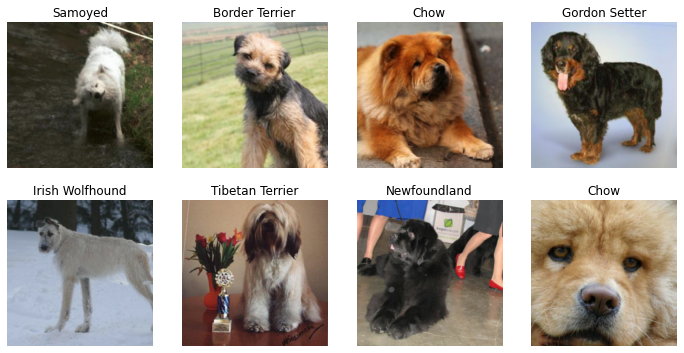

In [9]:
dog_breeds_nn = DogBreedsNN(dataset_path)
dog_breeds_nn.SHOW_FIGURES = True
Path.BASE_PATH = dog_breeds_nn.DATASET_PATH
print(dog_breeds_nn.DATASET_PATH)
dog_breeds_nn.AI_MODEL_FILENAME = 'dog_breeds_nn_model_export.pkl'
dog_breeds_nn.setup()

In [10]:
dog_breeds_nn.run()

epoch,train_loss,valid_loss,error_rate,time
0,1.524906,0.614395,0.177843,01:45
1,0.930443,0.546949,0.165452,01:46
2,0.761261,0.514222,0.154762,01:47


epoch,train_loss,valid_loss,error_rate,time
0,0.639712,0.516695,0.154519,02:21
1,0.772943,0.663118,0.197036,02:20
2,0.637650,0.598135,0.167396,02:20
3,0.427529,0.525225,0.152332,02:20
4,0.244628,0.477104,0.138970,02:20
5,0.173910,0.469593,0.134354,02:20


In [11]:
dog_breeds_nn.save()

In [12]:
dog_breeds_nn.EXAMPLE_IMAGE_FILEPATH = dog_breeds_nn.DATASET_PATH / 'n02085782-Japanese_spaniel/n02085782_50.jpg'

In [13]:
dog_breeds_nn.test(dog_breeds_nn.EXAMPLE_IMAGE_FILEPATH)

63.50% sure this is a Japanese Spaniel


In [14]:
photo = PILImage.create(dog_breeds_nn.DATASET_PATH / 'random_dog.jpg')

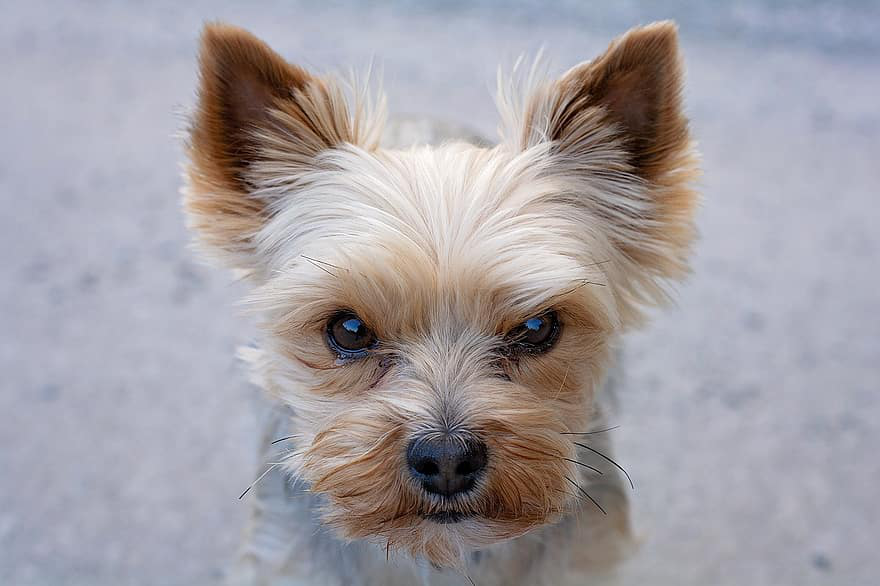

In [15]:
photo

In [18]:
dog_breeds_nn.test(dog_breeds_nn.DATASET_PATH / 'random_dog.jpg')

99.42% sure this is a Yorkshire Terrier
